## User Engagement analysis

#### importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sys
import os

#### read cleaned csv data

In [2]:
try:
    clean_data = pd.read_csv('../data/clean_data.csv')
except BaseException:
    logging.error('either file not found or wrong format')
    
print(clean_data.shape)
clean_data = clean_data.dropna()
clean_data.info()

(150001, 45)
<class 'pandas.core.frame.DataFrame'>
Index: 120739 entries, 0 to 149999
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Bearer Id                       120739 non-null  float64
 1   Start                           120739 non-null  object 
 2   Start ms                        120739 non-null  float64
 3   End                             120739 non-null  object 
 4   End ms                          120739 non-null  float64
 5   Dur. (ms)                       120739 non-null  float64
 6   IMSI                            120739 non-null  float64
 7   MSISDN/Number                   120739 non-null  float64
 8   IMEI                            120739 non-null  float64
 9   Last Location Name              120739 non-null  object 
 10  Avg RTT DL (ms)                 120739 non-null  float64
 11  Avg RTT UL (ms)                 120739 non-null  float64
 12  Avg Bear

#### Calculate the number of sessions per user

In [3]:
session_frequency = clean_data.groupby('MSISDN/Number')['Bearer Id'].count().reset_index()
session_frequency.columns = ['MSISDN/Number', 'Sessions Frequency']
session_frequency.sort_values(by=['Sessions Frequency'], ascending=False)



,MSISDN/Number,Sessions Frequency
30553,3.365973e+10,16
10624,3.362578e+10,16
63007,3.367588e+10,15
53846,3.366716e+10,13
71260,3.369879e+10,11
...,...,...
33454,3.366056e+10,1
33453,3.366056e+10,1
33452,3.366056e+10,1
33451,3.366055e+10,1


#### Calculate the total session duration per user

In [4]:
session_duration = clean_data.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index()
session_duration.columns = ['MSISDN/Number', 'Total Session Duration (ms)']

# Convert duration to seconds for better readability
session_duration['Total Session Duration (s)'] = session_duration['Total Session Duration (ms)'] / 1000

session_duration.sort_values(by=['Total Session Duration (s)'], ascending=False)
#plt.scatter(session_duration['MSISDN/Number'], session_duration['Total Session Duration (s)'])

,MSISDN/Number,Total Session Duration (ms),Total Session Duration (s)
10624,3.362578e+10,16694427.0,16694.427
53846,3.366716e+10,8744914.0,8744.914
5186,3.361489e+10,6049275.0,6049.275
54608,3.366746e+10,5649882.0,5649.882
540,3.360313e+10,5224283.0,5224.283
...,...,...,...
20121,3.365043e+10,7267.0,7.267
70193,3.369839e+10,7258.0,7.258
29026,3.365933e+10,7189.0,7.189
50241,3.366566e+10,7146.0,7.146


#### Calculate the total traffic (download and upload) per user

In [5]:
total_traffic = clean_data.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().reset_index()
total_traffic['Total Traffic (Bytes)'] = total_traffic['Total DL (Bytes)'] + total_traffic['Total UL (Bytes)']



#### Merge the calculated metrics into a single DataFrame based on the user's MSISDN/Number

In [6]:
engagement_metrics = pd.merge(session_frequency, session_duration, on='MSISDN/Number')
engagement_metrics = pd.merge(engagement_metrics, total_traffic[['MSISDN/Number', 'Total Traffic (Bytes)']], on='MSISDN/Number')
engagement_metrics

,MSISDN/Number,Sessions Frequency,Total Session Duration (ms),Total Session Duration (s),Total Traffic (Bytes)
0,3.360100e+10,1,116720.0,116.720,8.786906e+08
1,3.360100e+10,1,181230.0,181.230,1.568596e+08
2,3.360101e+10,1,49878.0,49.878,4.223207e+08
3,3.360101e+10,2,37104.0,37.104,1.457411e+09
4,3.360101e+10,1,128088.0,128.088,1.943679e+08
...,...,...,...,...,...
87821,3.378996e+10,1,98826.0,98.826,6.457777e+08
87822,3.378997e+10,1,160461.0,160.461,2.081231e+08
87823,3.378998e+10,1,31864.0,31.864,3.716556e+08
87824,3.379000e+10,1,8810.0,8.810,7.146416e+08


#### Now, engagement_metrics DataFrame contains the calculated engagement metrics.

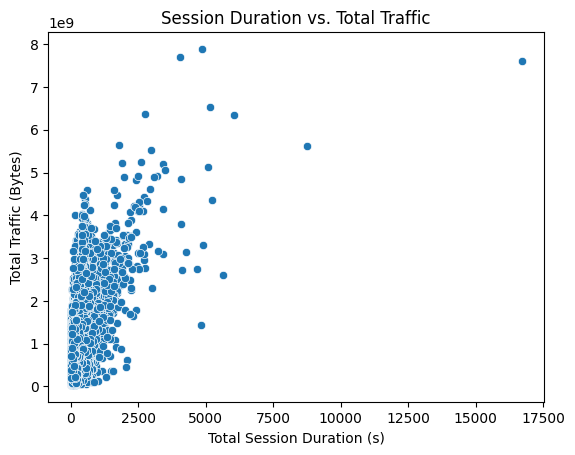

In [7]:
sns.scatterplot(x='Total Session Duration (s)', y='Total Traffic (Bytes)', data=engagement_metrics)
plt.title('Session Duration vs. Total Traffic')
plt.xlabel('Total Session Duration (s)')
plt.ylabel('Total Traffic (Bytes)')
plt.show()

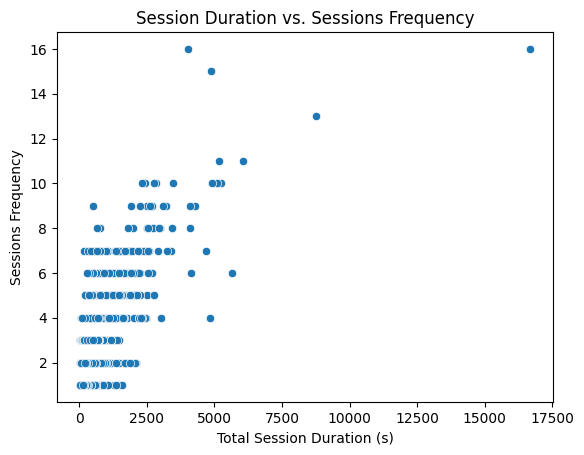

In [8]:
sns.scatterplot(x='Total Session Duration (s)', y='Sessions Frequency', data=engagement_metrics)
plt.title('Session Duration vs. Sessions Frequency')
plt.xlabel('Total Session Duration (s)')
plt.ylabel('Sessions Frequency')
plt.show()

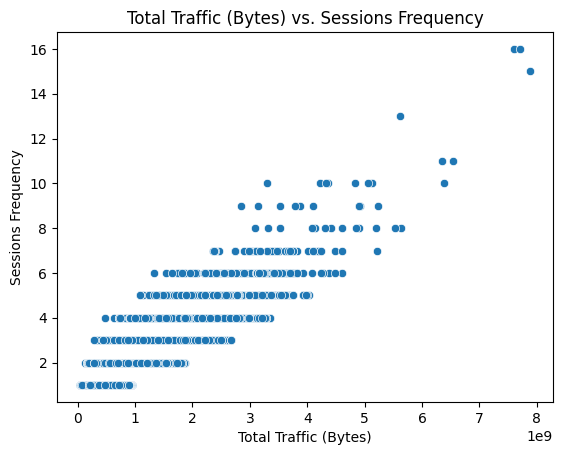

In [9]:
sns.scatterplot(x='Total Traffic (Bytes)', y='Sessions Frequency', data=engagement_metrics)
plt.title('Total Traffic (Bytes) vs. Sessions Frequency')
plt.xlabel('Total Traffic (Bytes)')
plt.ylabel('Sessions Frequency')
plt.show()

#### the top 10 customers per engagement metric

In [10]:
# Aggregate engagement metrics per customer ID
engagement_metrics_per_customer = pd.merge(session_frequency, session_duration, on='MSISDN/Number')
engagement_metrics_per_customer = pd.merge(engagement_metrics_per_customer, total_traffic[['MSISDN/Number', 'Total Traffic (Bytes)']], on='MSISDN/Number')

# Aggregate metrics per customer ID
agg_metrics_per_customer = engagement_metrics_per_customer.groupby('MSISDN/Number').agg({
    'Sessions Frequency': 'sum',
    'Total Session Duration (s)': 'sum',
    'Total Traffic (Bytes)': 'sum'
}).reset_index()

# Report the top 10 customers for each engagement metric
top_10_sessions_frequency = agg_metrics_per_customer.nlargest(10, 'Sessions Frequency')
top_10_session_duration = agg_metrics_per_customer.nlargest(10, 'Total Session Duration (s)')
top_10_total_traffic = agg_metrics_per_customer.nlargest(10, 'Total Traffic (Bytes)')

# Display the results
print("Top 10 Customers by Sessions Frequency:")
print(top_10_sessions_frequency)

print("\nTop 10 Customers by Total Session Duration:")
print(top_10_session_duration)

print("\nTop 10 Customers by Total Traffic:")
print(top_10_total_traffic)

Top 10 Customers by Sessions Frequency:
       MSISDN/Number  Sessions Frequency  Total Session Duration (s)  \
10624   3.362578e+10                  16                   16694.427   
30553   3.365973e+10                  16                    4035.428   
63007   3.367588e+10                  15                    4865.947   
53846   3.366716e+10                  13                    8744.914   
5186    3.361489e+10                  11                    6049.275   
71260   3.369879e+10                  11                    5169.128   
540     3.360313e+10                  10                    5224.283   
10896   3.362632e+10                  10                    5102.305   
11233   3.362695e+10                  10                    2415.036   
29152   3.365936e+10                  10                    2332.674   

       Total Traffic (Bytes)  
10624           7.608777e+09  
30553           7.705863e+09  
63007           7.891111e+09  
53846           5.618394e+09  
5186        

#### Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement

c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Customer Clusters:
       MSISDN/Number  Cluster
0       3.360100e+10        0
1       3.360100e+10        0
2       3.360101e+10        0
3       3.360101e+10        2
4       3.360101e+10        0
...              ...      ...
87821   3.378996e+10        0
87822   3.378997e+10        0
87823   3.378998e+10        0
87824   3.379000e+10        0
87825   3.379000e+10        0

[87826 rows x 2 columns]


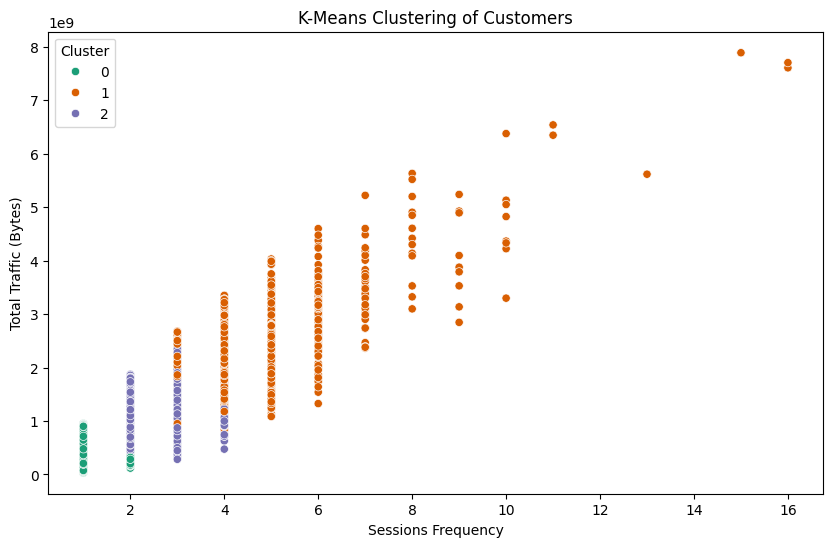

In [23]:
# Extract the engagement metrics
engagement_metrics = agg_metrics_per_customer[['Sessions Frequency', 'Total Session Duration (s)', 'Total Traffic (Bytes)']]

# Normalize the engagement metrics using StandardScaler
scaler = StandardScaler()
normalized_engagement_metrics = scaler.fit_transform(engagement_metrics)

# Run KMeans clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
agg_metrics_per_customer['Cluster'] = kmeans.fit_predict(normalized_engagement_metrics)

# Display the results
print("Customer Clusters:")
print(agg_metrics_per_customer[['MSISDN/Number', 'Cluster']])

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sessions Frequency', y='Total Traffic (Bytes)', hue='Cluster', data=agg_metrics_per_customer, palette='Dark2')
plt.title('K-Means Clustering of Customers')
plt.xlabel('Sessions Frequency')
plt.ylabel('Total Traffic (Bytes)')
plt.show()

#### Compute the minimum, maximum, average & total non-normalized metrics for each cluster

Cluster Metrics Summary:
  Cluster Sessions Frequency                      Total Session Duration (s)  \
                         min max      mean    sum                        min   
0       0                  1   2  1.022650  68087                      7.142   
1       1                  1  16  4.279525  13335                     66.594   
2       2                  1   4  2.168496  39317                     21.519   

                                      Total Traffic (Bytes)                \
         max        mean          sum                   min           max   
0    869.830   90.972366  6056849.188            33249009.0  9.507607e+08   
1  16694.427  601.610938  1874619.684           351234088.0  7.891111e+09   
2   1299.381  202.712995  3675389.311           118487293.0  2.509057e+09   

                               
           mean           sum  
0  4.938898e+08  3.288269e+13  
1  2.212888e+09  6.895360e+12  
2  1.103593e+09  2.000925e+13  


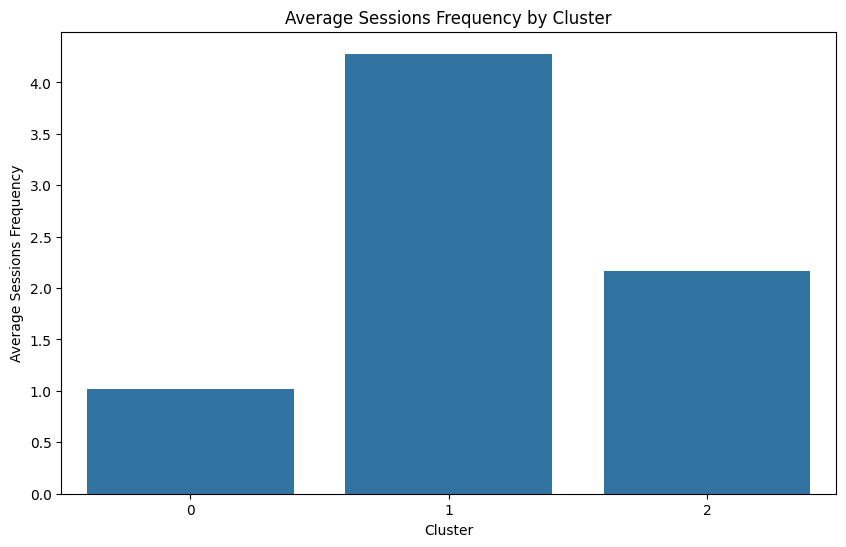

In [12]:
# Extract the engagement metrics
engagement_metrics = agg_metrics_per_customer[['MSISDN/Number', 'Sessions Frequency', 'Total Session Duration (s)', 'Total Traffic (Bytes)']]

# Add the cluster labels to the engagement_metrics DataFrame
engagement_metrics['Cluster'] = agg_metrics_per_customer['Cluster']

# Compute non-normalized metrics for each cluster
cluster_metrics_summary = engagement_metrics.groupby('Cluster').agg({
    'Sessions Frequency': ['min', 'max', 'mean', 'sum'],
    'Total Session Duration (s)': ['min', 'max', 'mean', 'sum'],
    'Total Traffic (Bytes)': ['min', 'max', 'mean', 'sum']
}).reset_index()

# Display the results
print("Cluster Metrics Summary:")
print(cluster_metrics_summary)

# Visualize the results (example: bar plots)
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Bar plot for Sessions Frequency
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y=('Sessions Frequency', 'mean'), data=cluster_metrics_summary)
plt.title('Average Sessions Frequency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sessions Frequency')
plt.show()

#### Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [19]:
# Select columns related to different applications
applications_columns = ['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']

# Create a new DataFrame with user ID and total traffic for each application
user_application_traffic = clean_data[['MSISDN/Number'] + applications_columns].copy()

# Sum the traffic for each user across all applications
user_application_traffic['Total Traffic'] = user_application_traffic[applications_columns].sum(axis=1)

# Sort users based on total traffic for each application
top_users_by_application = user_application_traffic.sort_values(by='Total Traffic', ascending=False)

# Display the top 10 users for each application
top_10_users_per_application = {}
for app_column in applications_columns:
    top_10_users = top_users_by_application[['MSISDN/Number', app_column]].nlargest(10, app_column)
    top_10_users_per_application[app_column] = top_10_users

# Print or further analyze the top 10 users for each application
for app_column, top_users in top_10_users_per_application.items():
    print(f"\nTop 10 Users for {app_column}:")
    print(top_users)


Top 10 Users for Social Media DL (Bytes):
        MSISDN/Number  Social Media DL (Bytes)
98327    3.368573e+10                3586064.0
118482   3.366292e+10                3586034.0
4711     3.378290e+10                3586000.0
60440    3.366102e+10                3585997.0
106935   3.368175e+10                3585895.0
71027    3.360332e+10                3585888.0
23294    3.376344e+10                3585883.0
114848   3.377703e+10                3585872.0
130307   3.366642e+10                3585858.0
69710    3.364565e+10                3585852.0

Top 10 Users for Youtube DL (Bytes):
        MSISDN/Number  Youtube DL (Bytes)
99496    3.367945e+10          23259098.0
102100   3.366957e+10          23258814.0
43028    3.368483e+10          23258701.0
95841    3.365088e+10          23258586.0
67084    3.375292e+10          23258375.0
78192    3.365822e+10          23258332.0
853      3.366432e+10          23258289.0
116605   3.366165e+10          23257591.0
76804    3.365873e+10   

#### 	Plot the top 3 most used applications using appropriate charts

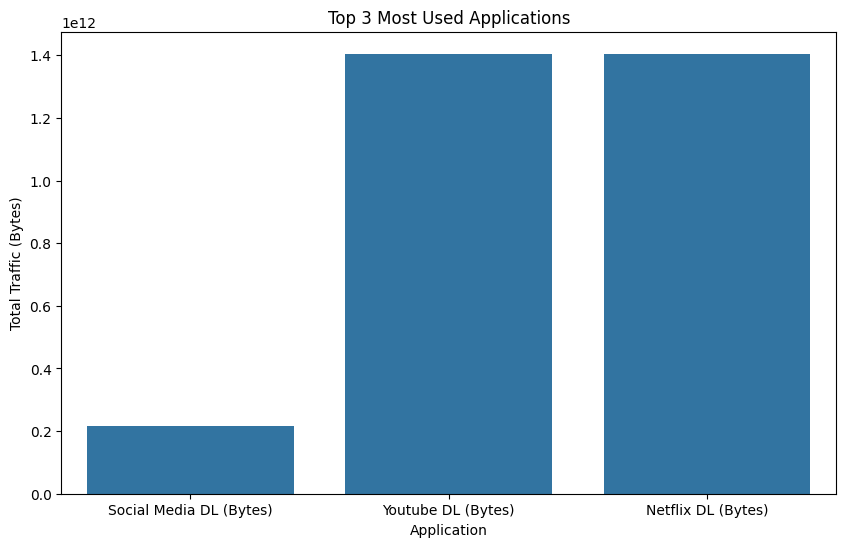

In [21]:
# Select the top 3 applications
top_3_applications = top_users_by_application[['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)']]

# Calculate the total traffic for each application
total_traffic_per_application = top_3_applications.sum()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=total_traffic_per_application.index, y=total_traffic_per_application.values)
plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.show()

#### Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics

c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

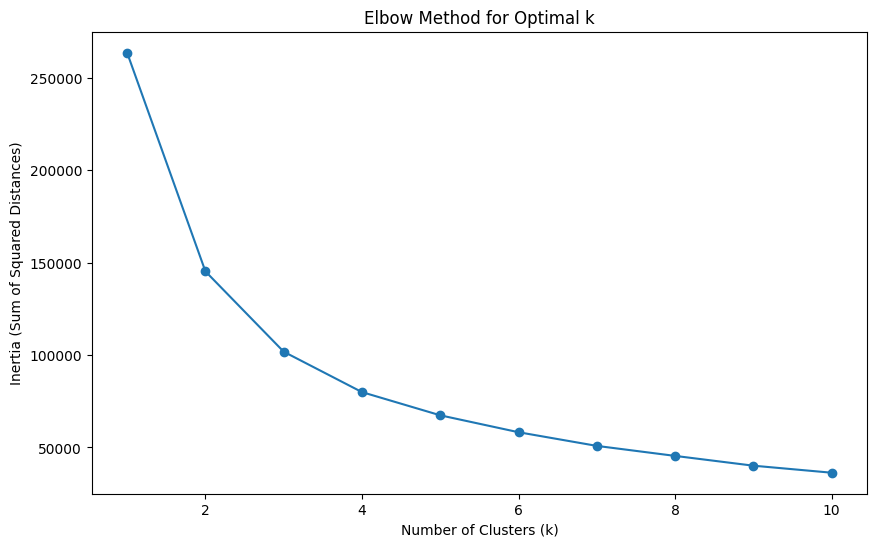

In [22]:
# Extract the engagement metrics
engagement_metrics = engagement_metrics_per_customer[['Sessions Frequency', 'Total Session Duration (s)', 'Total Traffic (Bytes)']]

# Normalize the engagement metrics using StandardScaler
scaler = StandardScaler()
normalized_engagement_metrics = scaler.fit_transform(engagement_metrics)

# Run k-means clustering for a range of values of k
inertia_values = []
possible_k_values = range(1, 11)  # You can adjust the range based on your data and requirements

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_engagement_metrics)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()